# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

## Proyecto de Mentoría: _Predicción de Series Temporales Financieras con Machine Learning_

### Trabajo Práctico 3: _Aprendizaje Supervisado y/o No Supervisado_

Grupo 1:

- Juan Cruz Gonzalez
- Marcelo Fernando Fullana Jornet
- Emanuel Nicolás Herrador
- Griselda Itovich
- Ariel Maximiliano Pereira

---


## 0. Índice (TODO)

- [1. Introducción](#1-introducción)
- [2. Desarrollo previo](#2-desarrollo-previo)
  - [2.1. Importación de librerías](#21-importación-de-librerías)
  - [2.2. Carga del dataset](#22-carga-del-dataset)
  - [2.3. Creación de *lags*](#23-creación-de-lags)
  - [2.4. División en conjuntos de entrenamiento y evaluación](#24-división-en-conjuntos-de-entrenamiento-y-evaluación)
- [3. Modelos básicos de Aprendizaje Supervisado](#3-modelos-básicos-de-aprendizaje-supervisado)
  - [3.1. Funciones auxiliares](#31-funciones-auxiliares)
  - [3.2. Evaluación de los modelos y búsqueda de hiperparámetros](#32-evaluación-de-los-modelos-y-búsqueda-de-hipérparámetros)
  - [3.3. Análisis de las predicciones realizadas](#33-análisis-de-las-predicciones-realizadas)
- [4. Modelos ARIMA](#4-modelos-arima)
  - [4.1. ¿Qué es? ¿Cómo funciona?](#41-qué-es-cómo-funciona)
  - [4.2. Ajuste del modelo ARIMA](#42-ajuste-del-modelo-arima)
    - [4.2.1. Ajuste manual](#421-ajuste-manual)
    - [4.2.2. Ajuste automático](#422-ajuste-automático)
  - [4.3. Entrenamiento y predicción](#43-entrenamiento-y-predicción)
- [5. Modelos con Redes Neuronales](#5-modelos-con-redes-neuronales)
  - [5.1. MLP (Multilayer Perceptron)](#51-mlp-multilayer-perceptron)
    - [5.1.1. Funcionamiento y transformación de los datos](#511-funcionamiento-y-transformación-de-los-datos)
    - [5.1.2. Búsqueda de hiperparámetros](#512-búsqueda-de-hiperparámetros)
    - [5.1.3. Predicción y análisis de resultados](#513-predicción-y-análisis-de-resultados)
  - [5.2. LSTM (Long Short Term Memory)](#52-lstm-long-short-term-memory)
    - [5.2.1. Funcionamiento y transformación de los datos](#521-funcionamiento-y-transformación-de-los-datos)
    - [5.2.2. Predicción y análisis de resultados](#522-predicción-y-análisis-de-resultados)
- [6. Conclusiones](#6-conclusiones)

## 1. Introducción

En el presente trabajo, se realizará la predicción de los valores de la serie temporal de datos de precios de las acciones de la empresa Tesla Inc. (TSLA), que cotiza en la bolsa de valores NASDAQ desde el 29 de junio de 2010. Los datos que se tendrán en cuenta serán los [mismos](https://raw.githubusercontent.com/Emmatassone/Mentoria_FaMAF_2024/main/tsla_split_adjusted.csv) que en los trabajos prácticos anteriores, por lo que corresponden al período comprendido entre el 29 de junio de 2010 y el 15 de abril de 2024.

El objetivo de este trabajo es realizar una comparación entre diferentes modelos de aprendizaje supervisado y no supervisado para la predicción de series temporales financieras. Para ello, se utilizarán modelos básicos de aprendizaje supervisado, modelos ARIMA y modelos con redes neuronales. La forma de comparación será a través de la evaluación de los modelos y el cálculo de métricas de error como el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE).

## 2. Desarrollo previo

En esta sección importaremos las librerías a usar en el presente trabajo, se cargará el dataset y se harán las transformaciones necesarias para poder trabajar con los datos y realizar las predicciones.

Consideraremos el período 2020-2024 por lo observado en anteriores trabajos, dado que es el período en el que se observa el mayor crecimiento de Tesla (2020) llegando a su máximo histórico en *Noviembre* de 2021. Luego, el período a considerar es el comprendido entre el *1 de Enero de 2020* y el *15 de Abril de 2024*.

### 2.1. Importación de librerías

Las librerías que se utilizarán en este trabajo son las siguientes:

In [1]:
# Instalamos las librerías necesarias
%pip install pmdarima

# Importamos las librerías
import numpy as np
import pandas as pd
from datetime import datetime

# Visualización
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from plotly.subplots import make_subplots

# Preprocesamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Evaluación de modelos
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Análisis de series temporales
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from pmdarima import auto_arima

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Seteamos la seed para reproducibilidad
random_seed = 0
np.random.seed(random_seed)

### 2.2. Carga del dataset

En esta sección, procederemos con la carga del dataset que utilizaremos:

In [2]:
file_url = 'https://raw.githubusercontent.com/Emmatassone/Mentoria_FaMAF_2024/main/tsla_split_adjusted.csv'
df = pd.read_csv(file_url)

# Colocar la fecha como tipo datetime
df['date'] = pd.to_datetime(df['date'])

# Nos quedaremos con el período 2020-01-01 al 2024-04-15
df = df[(df['date'] >= '2020-01-01') & (df['date'] <= '2024-04-15')]

# Colocar los demás valores de tipo float excepto volume
float_features = ['open', 'high', 'low', 'close',
                  'raw_close', 'change_percent', 'avg_vol_20d']
int_features = ['volume']

for feature in float_features:
    df[feature] = df[feature].astype(float)
for feature in int_features:
    df[feature] = df[feature].astype(int)

# Mostrar las primeras filas del dataset para chequear
df.head()

,date,open,high,low,close,volume,raw_close,change_percent,avg_vol_20d
2394,2020-01-02,28.30000,28.71304,28.11400,28.68400,143375784,430.2600,2.85,1.531261e+08
2395,2020-01-03,29.36666,30.26666,29.12800,29.53400,266920473,443.0100,2.96,1.623200e+08
2396,2020-01-06,29.36466,30.10400,29.33334,30.10266,152362493,451.5399,1.93,1.671354e+08
2397,2020-01-07,30.76000,31.44200,30.22366,31.27066,273137103,469.0599,3.88,1.750780e+08
2398,2020-01-08,31.58000,33.23266,31.21534,32.80934,467990844,492.1401,4.92,1.916974e+08


Con esto en mente, vamos a agregar los días faltantes (feriados y fines de semana) y completar sus valores utilizando interpolación lineal (tal y como hicimos en el trabajo número 2).

Primero, agregamos los días faltantes:

In [3]:
# Agregamos todos los días en el rango 01/01/2020 - 15/04/2024
df_full = df.copy()
df_full = pd.merge(pd.DataFrame(pd.date_range(start='2020-01-01', end='2024-04-15',
                   freq='D'), columns=['date']), df_full, how='left', on='date')

display(pd.DataFrame({'Cantidad de días': [
        df.shape[0], df_full.shape[0]]}, index=['Antes', 'Después']).T)

,Antes,Después
Cantidad de días,1078,1567


Con ello, podemos observar los valores faltantes en el dataset:

In [4]:
fig = go.Figure()
fig.add_trace(go.Bar(x=df_full.columns,
              y=df_full.notnull().sum(), marker_color='tomato'))
fig.update_layout(title='Valores faltantes en el dataset de Tesla',
                  xaxis_title='Columnas', yaxis_title='Cantidad no nula')
fig.show()

Gracias a lo cual se puede observar que hay muchísimos valores que faltan. Por esto mismo, hacemos la interpolación:

In [5]:
# Interpolamos los valores faltantes
for feature in df_full.columns[1:]:
    df_full[feature] = df_full[feature].interpolate()

# Eliminamos el primer día si llega a ser NaN
df_full = df_full.dropna()

# Bar plot de valores faltantes
fig = go.Figure()
fig.add_trace(go.Bar(x=df_full.columns, y=df_full.notnull().sum(),
              marker_color='mediumseagreen'))
fig.update_layout(title='Valores faltantes en el dataset de Tesla',
                  xaxis_title='Columnas', yaxis_title='Cantidad no nula')
fig.show()

Y, finalmente, gracias a ello podemos obtener el dataset completo con el que comenzaremos a trabajar.

### 2.3. Creación de *lags*

Con el objetivo de realizar las predicciones en la serie temporal, crearemos nuevas columnas para cada *lag* de la serie temporal (considerando un máximo de 30 *lags*). Nos quedaremos únicamente con las columnas de *Close* y sus *lags*.

In [6]:
# Nos quedamos solo con Close
df_full = df_full[['date', 'close']]

# Generamos los lags
cnt_lags = 30
for lag in range(1, cnt_lags + 1):
    df_full[f'close_lag_{lag}'] = df_full['close'].shift(lag)

# Eliminamos los valores faltantes y seteamos la fecha como índice
df_full = df_full.dropna()
df_full.set_index('date', inplace=True)

# Mostramos las primeras filas del dataset
df_full.head()

,close,close_lag_1,close_lag_2,close_lag_3,close_lag_4,close_lag_5,close_lag_6,close_lag_7,close_lag_8,close_lag_9,...,close_lag_21,close_lag_22,close_lag_23,close_lag_24,close_lag_25,close_lag_26,close_lag_27,close_lag_28,close_lag_29,close_lag_30
date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,46.24756,43.37134,42.72066,38.73266,37.79334,37.20134,37.352447,37.503553,37.654660,38.146660,...,32.91466,31.87666,32.08934,32.80934,31.27066,30.10266,29.913107,29.723553,29.534000,28.684000
2020-02-02,49.12378,46.24756,43.37134,42.72066,38.73266,37.79334,37.201340,37.352447,37.503553,37.654660,...,33.95266,32.91466,31.87666,32.08934,32.80934,31.27066,30.102660,29.913107,29.723553,29.534000
2020-02-03,52.00000,49.12378,46.24756,43.37134,42.72066,38.73266,37.793340,37.201340,37.352447,37.503553,...,34.99066,33.95266,32.91466,31.87666,32.08934,32.80934,31.270660,30.102660,29.913107,29.723553
2020-02-04,59.13734,52.00000,49.12378,46.24756,43.37134,42.72066,38.732660,37.793340,37.201340,37.352447,...,35.86134,34.99066,33.95266,32.91466,31.87666,32.08934,32.809340,31.270660,30.102660,29.913107
2020-02-05,48.98000,59.13734,52.00000,49.12378,46.24756,43.37134,42.720660,38.732660,37.793340,37.201340,...,34.56666,35.86134,34.99066,33.95266,32.91466,31.87666,32.089340,32.809340,31.270660,30.102660


### 2.4. División en conjuntos de entrenamiento y evaluación

Y, por último, dividimos el dataset en conjuntos de entrenamiento y evaluación para poder ajustar los hipérparámetros de los modelos, evaluar su desempeño y compararlos. 

Para ello, la fecha que utilizaremos para dividir el dataset en un $70/30$ será:

In [7]:
cnt_days = (datetime(2024, 4, 15) - datetime(2020, 1, 1)).days
limit_date = datetime(2020, 1, 1) + pd.DateOffset(days=cnt_days*0.7)

print(f'Fecha límite: {limit_date}')

Fecha límite: 2023-01-01 00:00:00


Luego, entonces, la fecha límite es el *1 de Enero de 2023*. Haciendo la división en entrenamiento y evaluación tenemos lo siguiente:

In [8]:
X_train = df_full[df_full.index < limit_date].drop('close', axis=1)
y_train = df_full[df_full.index < limit_date]['close']

X_test = df_full[df_full.index >= limit_date].drop('close', axis=1)
y_test = df_full[df_full.index >= limit_date]['close']

print(f'Tamaños: X_train = {X_train.shape}, y_train = {y_train.shape}')
print(f'         X_test = {X_test.shape}, y_test = {y_test.shape}')

Tamaños: X_train = (1065, 30), y_train = (1065,)
         X_test = (471, 30), y_test = (471,)


Con todo ello, entonces, ya podemos comenzar con el entrenamiento de los modelos y la evaluación de los mismos.

## 3. Modelos básicos de Aprendizaje Supervisado

En esta sección nos enfocaremos de lleno en el ajuste de los siguientes modelos:

- **Regresión Lineal**
- **Random Forest Regressor**
- **SVR (Support Vector Regression)**

Para predecir el precio de cierre del conjunto de testeo. Los rendimientos se evaluarán en base a su MAE (*Mean Absolute Error*) y RMSE (*Root Mean Squared Error*).

### 3.1. Funciones auxiliares

Para ello, consideraremos las siguientes funciones auxiliares que nos serán de suma utilidad:

In [9]:
def get_default_models_performance(models, X_train, y_train, X_test, y_test):
    print('Obteniendo resultados de los modelos por defecto...')

    results = []
    trained_models = []
    for model in models:
        print(f'    Viendo {model.__class__.__name__}...')

        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        results.append({
            'Modelo': model.__class__.__name__,
            'MAE Train': mean_absolute_error(y_train, y_pred_train),
            'MAE Test': mean_absolute_error(y_test, y_pred_test),
            'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test))
        })
        trained_models.append(model)

    return pd.DataFrame(results), trained_models


def get_hyperparameters_performance(models, param_grids, X_train, y_train, X_test, y_test):
    print('Obteniendo resultados de los modelos con búsqueda de hiperparámetros...')

    results = []
    trained_models = []
    for model, params in zip(models, param_grids):
        print(f'    Viendo {model.__class__.__name__}...')

        grid_search = GridSearchCV(
            model, params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        y_pred_train = grid_search.predict(X_train)
        y_pred_test = grid_search.predict(X_test)

        results.append({
            'Modelo': model.__class__.__name__,
            'Parámetros': grid_search.best_params_,
            'MAE Train': mean_absolute_error(y_train, y_pred_train),
            'MAE Test': mean_absolute_error(y_test, y_pred_test),
            'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
            'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test))
        })
        trained_models.append(grid_search.best_estimator_)

    return pd.DataFrame(results), trained_models


def get_model_performance_graphic(results, title):
    fig = make_subplots(rows=1, cols=2, subplot_titles=(
        'MAE de los modelos', 'RMSE de los modelos'))

    fig.add_trace(go.Bar(x=results['Modelo'], y=results['MAE Train'],
                  marker_color='tomato', name='Train'), row=1, col=1)
    fig.add_trace(go.Bar(x=results['Modelo'], y=results['MAE Test'],
                  marker_color='mediumseagreen', name='Test'), row=1, col=1)

    fig.add_trace(go.Bar(x=results['Modelo'], y=results['RMSE Train'],
                  marker_color='tomato', name='Train'), row=1, col=2)
    fig.add_trace(go.Bar(x=results['Modelo'], y=results['RMSE Test'],
                  marker_color='mediumseagreen', name='Test'), row=1, col=2)

    fig.update_layout(title_text=title, showlegend=False)
    fig.show()


def get_model_predictions_graphic(trained_models, X_train, y_train, X_test, y_test, full=False):
    fig = go.Figure()

    X, y = (np.concatenate((X_train.index, X_test.index)), np.concatenate(
        (y_train, y_test))) if full else (X_test.index, y_test)
    fig.add_trace(go.Scatter(x=X, y=y, mode='lines',
                  name='Real', marker_color='black'))

    for model in trained_models:
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        X, y = (np.concatenate((X_train.index, X_test.index)), np.concatenate(
            (y_pred_train, y_pred_test))) if full else (X_test.index, y_pred_test)
        fig.add_trace(go.Scatter(x=X, y=y, mode='lines',
                      name=model.__class__.__name__))

    title = f'Predicciones de los modelos en el conjunto {
        "completo" if full else "de test"}'
    fig.update_layout(title=title, xaxis_title='Fecha', yaxis_title='Close')
    fig.show()

### 3.2. Evaluación de los modelos y búsqueda de hipérparámetros

Con esto en mente, entonces, podemos ver los resultados de las predicciones de los modelos para el entrenamiento y la evaluación, tanto con hiperparámetros por defecto como con hiperparámetros ajustados:

In [10]:
models = [
    LinearRegression(),
    RandomForestRegressor(random_state=random_seed),
    SVR()
]

param_grids = [
    {
        'fit_intercept': [True, False],
        'n_jobs': [-1]
    },
    {
        'n_estimators': [10, 50, 100, 200],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        'max_depth': [None, 5, 10, 20],
        'n_jobs': [-1]
    },
    {
        'degree': [2, 3, 4],
        'C': [0.1, 1, 10],
        'tol': [1e-3, 1e-4, 1e-5],
        'epsilon': [0.1, 0.2, 0.3]
    }
]

model_result_default, trained_models_default = get_default_models_performance(
    models, X_train, y_train, X_test, y_test)
model_result_hyperparameters, trained_models_hyperparameters = get_hyperparameters_performance(
    models, param_grids, X_train, y_train, X_test, y_test)

Obteniendo resultados de los modelos por defecto...
    Viendo LinearRegression...
    Viendo RandomForestRegressor...
    Viendo SVR...
Obteniendo resultados de los modelos con búsqueda de hiperparámetros...
    Viendo LinearRegression...
    Viendo RandomForestRegressor...
    Viendo SVR...


Gracias a ello, tenemos los siguientes resultados:

In [11]:
print('============================== Resultados por defecto ==============================')
display(model_result_default)
get_model_performance_graphic(
    model_result_default, 'Resultados de los modelos por defecto')

print('==================== Resultados con búsqueda de hiperparámetros ====================')
display(model_result_hyperparameters)
get_model_performance_graphic(model_result_hyperparameters,
                              'Resultados de los modelos con búsqueda de hiperparámetros')

============================== Resultados por defecto ==============================


,Modelo,MAE Train,MAE Test,RMSE Train,RMSE Test
0,LinearRegression,4.283756,3.451215,6.488453,5.026196
1,RandomForestRegressor,1.755472,4.196760,2.708658,5.744156
2,SVR,18.158855,11.990646,26.037942,15.344843


==================== Resultados con búsqueda de hiperparámetros ====================


,Modelo,Parámetros,MAE Train,MAE Test,RMSE Train,RMSE Test
0,LinearRegression,"{'fit_intercept': False, 'n_jobs': -1}",4.287827,3.465485,6.497984,5.042019
1,RandomForestRegressor,"{'criterion': 'friedman_mse', 'max_depth': 5, ...",4.033408,4.126448,6.032023,5.680469
2,SVR,"{'C': 10, 'degree': 2, 'epsilon': 0.1, 'tol': ...",7.081975,5.468846,10.045870,7.370377


Donde podemos ver que el mejor resultado en validación lo obtiene *LinearRegression*, con un MAE de $4.12$ y un RMSE de $5.68$ en *test*.

### 3.3. Análisis de las predicciones realizadas

Para ver gráficamente si los modelos están haciendo un buen trabajo o no, podemos ver cuál es la aproximación que hace cada uno de ellos a la serie tanto en entrenamiento como en evaluación:

In [12]:
get_model_predictions_graphic(
    trained_models_default, X_train, y_train, X_test, y_test, full=True)
get_model_predictions_graphic(
    trained_models_default, X_train, y_train, X_test, y_test, full=False)

Luego, claramente `SVR` genera una *muy mala* predicción, mientras que `RandomForestRegressor` y `LinearRegression` tienen un comportamiento similar, siendo ligeramente mejor el segundo. Estos resultados (`RandomForestRegressor` y `LinearRegression`) pueden notarse que son confiables dado que el error en testeo es similar al error en entrenamiento (y ambos son valores chicos), no se genera overfitting y los modelos son capaces de generalizar (notar que usamos *cross-validation* para ajustar los hiperparámetros).

## 4. Modelos ARIMA

### 4.1. ¿Qué es? ¿Cómo funciona?

El modelo ARIMA (*AutoRegressive Integrated Moving Average*) es un método estadístico que se utiliza para modelar y predecir series temporales. Su objetivo es capturar las dependencias lineales y los patrones subyacentes de los datos, como las tendencias o la estacionalidad, para hacer predicciones.

Es una combinación de *tres componentes principales* que se expresan mediante los parámetros $p$, $d$ y $q$, y que modelan diferentes características de la serie temporal:

- **Auto-regresión (AR)** - $p$: modela la relación entre una observación y sus valores pasados. El valor representa el número de retardos o *lags* utilizados en el modelo.
- **Integración (I)** - $d$: relacionada con la diferenciación de la serie temporal para hacerla estacionaria (dado que este es un requisito fundamental para la aplicación de muchos modelos estadísticos, incluido ARIMA). El valor indica cuántas veces se diferencian los datos.
  - Tener en cuenta que una serie es estacionaria si sus propiedades estadísticas, como la media y la varianza, no cambian con el tiempo. Las series **no** estacionarias suelen tener tendencias o estacionalidades, lo que complica la modelización (notar que esto se eliminaría al diferenciar).
- **Promedio móvil (MA)** - $q$: modela la relación entre el valor actual y los errores o residuos de los valores pasados. El valor define cuántos términos de error anteriores se incluyen en el modelo.

Por ello mismo, podemos ver que ARIMA es un modelo lineal adecuado para series temporales que son estacionarias y que asume que las relaciones en los datos son consistentes con el tiempo (se presenta una relación lineal entre los valores pasados y futuros). Además, las series ideales para este modelo incluyen datos con tendencias estables o ciclos que pueden ser identificados mediante las componentes autoregresivas y de media móvil.

Para esta última parte, nos va a ser de suma utilidad el *Test de Hipótesis de Dickey-Fuller Aumentado* para determinar si una serie temporal es estacionaria o no. Este test se basa en la hipótesis nula de que la serie temporal tiene una raíz unitaria, lo que indica que la serie temporal no es estacionaria. Si el valor $p$ obtenido es menor que un umbral crítico (i.e., cercano a 0), entonces se rechaza la hipótesis nula y se considera que la serie temporal es estacionaria.

Teniendo todo esto en cuenta, podemos proceder con la implementación de ARIMA para predecir el precio de cierre de Tesla.

### 4.2. Ajuste del modelo ARIMA

Para el ajuste del modelo ARIMA vamos a considerar dos métodos principales: de forma *manual* utilizando el truco de de la Auto-Correlación Parcial de los residuos al cuadrado y analizando las probabilidades de los coeficientes en los resultados de los ajustes; y de forma *automática* utilizando la función `auto_arima` de la librería `pmdarima`.

Vamos a considerar ambos resultados que se obtengan, y analizar las predicciones de cada uno de los modelos, tanto obtenido de forma *manual* como *automática* (con la librería).

#### 4.2.1. Ajuste manual

Lo primero que tenemos que ver es si nuestra serie es o no es estacionaria. Para ello, vamos a realizar el *Test de Dickey-Fuller Aumentado*:

In [13]:
result = adfuller(y_train)

print('============================== Test de Dickey-Fuller ==============================')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')

============================== Test de Dickey-Fuller ==============================
ADF Statistic: -1.7308784456635342
p-value: 0.41527727929726227
Critical Values: {'1%': -3.4365517520261637, '5%': -2.86427826065702, '10%': -2.5682279541355597}


Luego, como nuestro p-valor es $0.42$, entonces *no podemos* rechazar con un nivel de significancia del $95\%$ la hipótesis nula de que la serie no es estacionaria. Por lo tanto, vamos a diferenciar la serie y volver a realizar el test para convertirla en estacionaria:

In [14]:
y_train_diff = y_train.diff().dropna()

result = adfuller(y_train_diff)

print('============================== Test de Dickey-Fuller ==============================')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values: {result[4]}')

============================== Test de Dickey-Fuller ==============================
ADF Statistic: -11.854439513348385
p-value: 7.082478521571474e-22
Critical Values: {'1%': -3.4365517520261637, '5%': -2.86427826065702, '10%': -2.5682279541355597}


Donde, en este caso, el p-valor es muy cercano a $0.0$, por lo que podemos rechazar la hipótesis nula y decir que la serie *diferenciada* (1 vez) es estacionaria. Por ello mismo, entonces, queda claro que $d=1$.

Ahora, respecto a $p,q$, tenemos que encontrar el mejor modelo ARIMA que se ajuste a ellos. Por esto mismo, vamos a usar el truco de la Auto-Correlación y Auto-Correlación Parcial de los datos para comenzar a buscar los valores de $p$ y $q$.

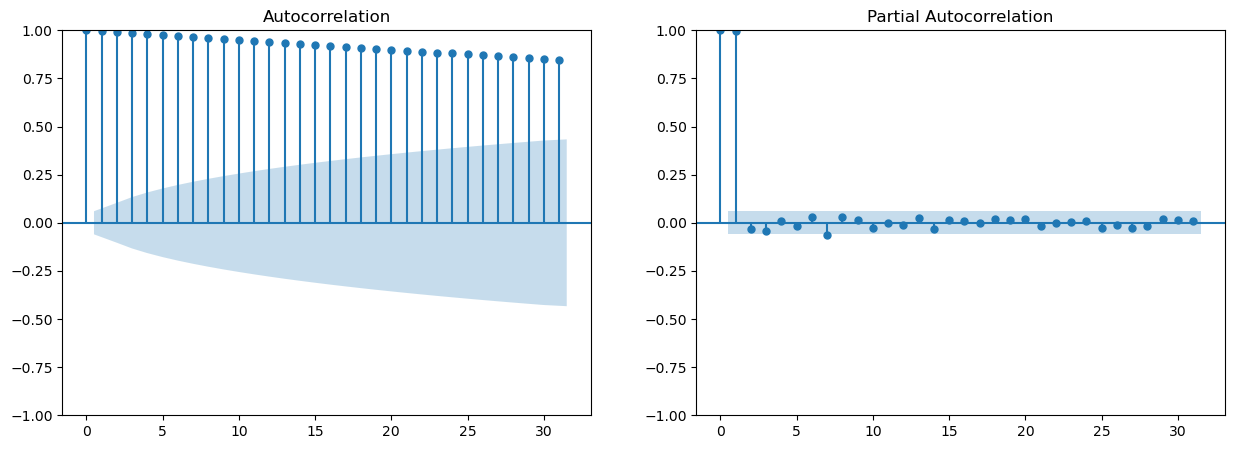

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(y_train, ax=ax[0])
plot_pacf(y_train, ax=ax[1])
plt.show()

Luego, como el corte abrupto de se da luego del 1er lag en la autocorrelación parcial, entonces comenzaremos a probar desde ARIMA(1, 1, 1):

In [16]:
model = ARIMA(y_train, order=(1, 1, 1), freq='D')
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1065
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3525.696
Date:                Mon, 23 Sep 2024   AIC                           7057.392
Time:                        20:52:36   BIC                           7072.301
Sample:                    02-01-2020   HQIC                          7063.041
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5195      0.217      2.391      0.017       0.094       0.945
ma.L1         -0.4410      0.225     -1.957      0.050      -0.883       0.001
sigma2        44.2289      0.933     47.387      0.0

Ahora, como las probabilidades de la columna `P>|z|` de los coeficientes son cercanas a $0$, entonces podemos decir que todos los coeficientes son significativos. Por lo tanto, este es un buen modelo sobre el cual ajustar la serie temporal.

Para verificar esto, vamos a graficar los residuos y chequear que sean ruido blanco:

In [17]:
residuals = pd.DataFrame(model_fit.resid)

fig = make_subplots(rows=1, cols=2, subplot_titles=(
    'Residuos', 'Densidad de los residuos'))

fig.add_trace(go.Scatter(x=y_train.index,
              y=residuals[0], mode='lines', name='Residuos'), row=1, col=1)
fig.add_trace(go.Histogram(x=residuals[0], name='Residuos'), row=1, col=2)

fig.update_layout(
    title='Análisis de los residuos del modelo ARIMA', showlegend=False)
fig.show()

Luego, como tiene forma de ruido blanco con media y varianza constantes (y sin patrones), entonces podemos decir que el modelo es bueno. Finalmente, entonces, se decide ajustar el modelo ARIMA(1, 1, 1).

#### 4.2.2. Ajuste automático

Para encontrar los $p, d, q$ óptimos, vamos a utilizar la función `auto_arima` de la librería `pmdarima`:

In [18]:
model = auto_arima(
    y_train,
    start_p=0, start_q=0,
    start_P=0, D=0,
    d=None, seasonal=False,
    max_p=5, max_q=5,
    test='adf',
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7064.222, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7060.685, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7061.464, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7062.335, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7056.063, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7057.761, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7055.548, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7059.307, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7059.507, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7049.267, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7057.580, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7042.964, Time=0.82 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=7044.387, Time=1.23 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7052.365, Time=1.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept

Y, a diferencia del ajuste manual, el modelo que mejor se ajusta a los datos es un ARIMA(4, 1, 4), el cual también utilizaremos para predecir nuestra serie temporal. Para corroborar que este modelo sea bueno, vamos a graficar los residuos y chequear que sean ruido blanco:

In [19]:
# Entrenamos el modelo ARIMA
model = ARIMA(y_train, order=(4, 1, 4), freq='D')
model_fit = model.fit()

# Vemos los residuos del modelo ARIMA
residuals = pd.DataFrame(model_fit.resid)

fig = make_subplots(rows=1, cols=2, subplot_titles=(
    'Residuos', 'Densidad de los residuos'))

fig.add_trace(go.Scatter(x=y_train.index,
              y=residuals[0], mode='lines', name='Residuos'), row=1, col=1)
fig.add_trace(go.Histogram(x=residuals[0], name='Residuos'), row=1, col=2)

fig.update_layout(
    title='Análisis de los residuos del modelo ARIMA', showlegend=False)
fig.show()

Luego, como tiene forma de ruido blanco con media y varianza constantes (y sin patrones), entonces podemos decir que el modelo es bueno. Finalmente, entonces, se decide ajustar el modelo ARIMA(4, 1, 4).

### 4.3. Entrenamiento y predicción

Primero, para que nos sea más sencillo el análisis, vamos a tener en cuenta la siguiente función auxiliar:

In [20]:
def graph_arima_predictions(model, y_train, y_test, cnt_train, cnt_test, title):
    y_train_2 = y_train[-cnt_train:]
    y_test_2 = y_test[:cnt_test]
    y = pd.concat([y_train_2, y_test_2])

    fc = model_fit.get_forecast(steps=cnt_test)
    pred = fc.predicted_mean
    lower, upper = fc.conf_int()['lower close'], fc.conf_int()['upper close']

    plt.figure(figsize=(15, 5))
    plt.plot(y.index, y, label='Real')
    plt.plot(y_test_2.index, pred, label='Predicción')
    plt.fill_between(y_test_2.index, lower, upper, alpha=0.3,
                     color='lightblue', label='Intervalo de confianza')
    plt.title(title)
    plt.xlabel('Fecha')
    plt.ylabel('Close')
    plt.legend()
    plt.show()

En este punto, vamos a realizar el correspondiente entrenamiento y predicción para cada uno de los modelos ARIMA considerados:

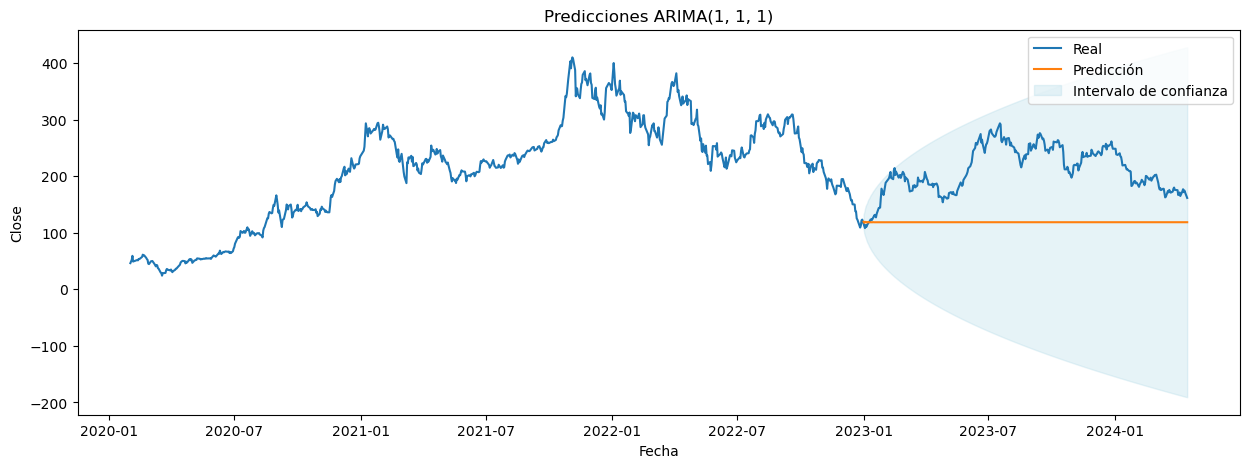

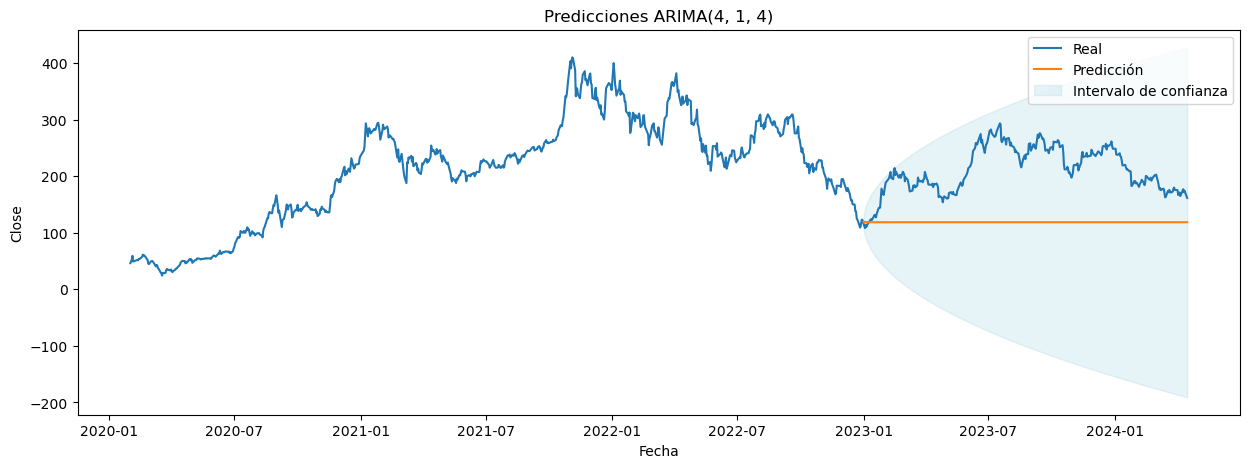

In [21]:
# ARIMA(1, 1, 1)
model_111 = ARIMA(y_train, order=(1, 1, 1), freq='D')
model_fit_111 = model_111.fit()

graph_arima_predictions(model_fit_111, y_train, y_test, len(
    y_train), len(y_test), 'Predicciones ARIMA(1, 1, 1)')

# ARIMA(4, 1, 4)
model_414 = ARIMA(y_train, order=(4, 1, 4), freq='D')
model_fit_414 = model_414.fit()

graph_arima_predictions(model_fit_414, y_train, y_test, len(
    y_train), len(y_test), 'Predicciones ARIMA(4, 1, 4)')

Con ello, podemos notar que claramente a lo largo del tiempo los modelos se vuelven una línea recta, lo cual no es bueno pero tiene todo el sentido ya que estamos considerando, a lo sumo, 4 *lags* (por el MA y AR) de la serie temporal. Si queremos ver una diferencia, en vez de graficar todos los días del 2020-2024, nos podemos concentrar en los primeros 10 días del 2023:

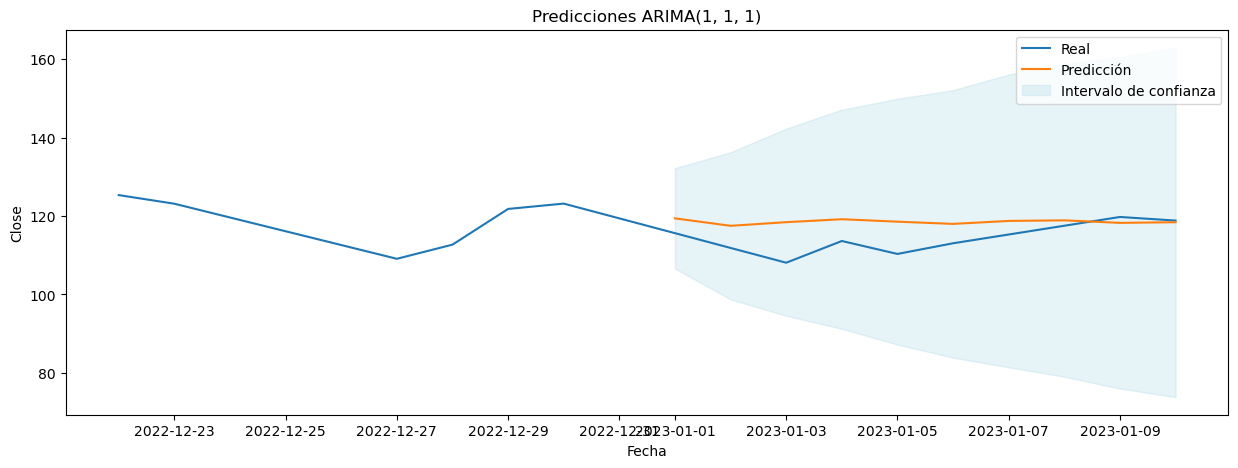

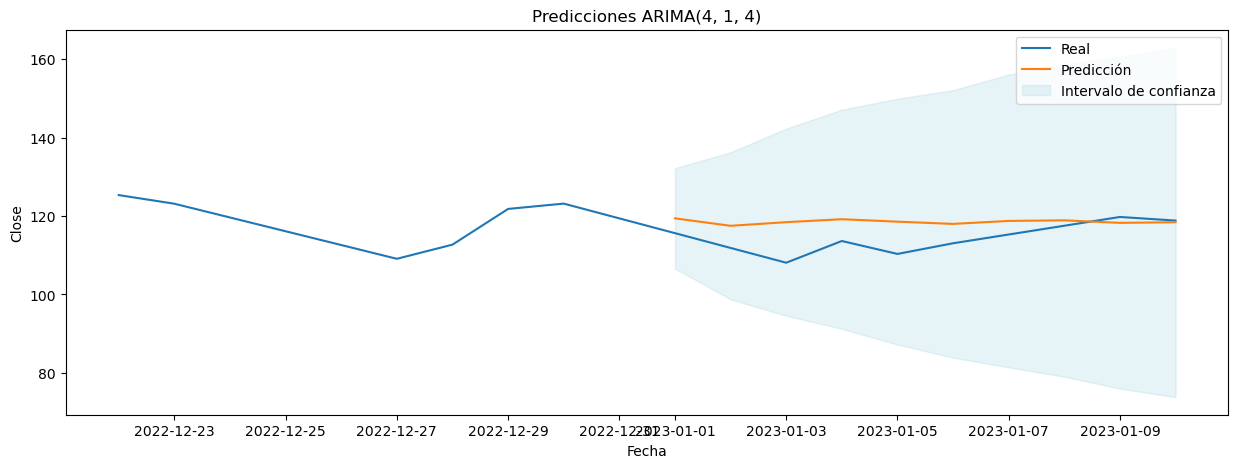

In [22]:
# ARIMA(1, 1, 1)
graph_arima_predictions(model_fit_111, y_train, y_test, 10,
                        10, 'Predicciones ARIMA(1, 1, 1)')

# ARIMA(4, 1, 4)
graph_arima_predictions(model_fit_414, y_train, y_test, 10,
                        10, 'Predicciones ARIMA(4, 1, 4)')

Si bien aquí podemos observar que no es lineal en los primeros días predichos, en el gráfico general (de predicción del 2023), podemos notar que no es un buen resultado el que obtuvimos, dado que simplemente se convierte rápidamente en una línea recta que termina siendo la media de los últimos valores del entrenamiento. Por ello mismo, entonces, estos modelos ARIMA no son los mejores para predecir el precio de cierre de Tesla. Algo que podríamos considerar para mejorar esta situación es usar un modelo GARCH para modelar la volatilidad de la serie temporal, y luego utilizar ARIMA para modelar la tendencia. Esto sería lo ideal para mejorar la predicción de la serie temporal, dado que ARIMA no es un buen modelo para series temporales con alta volatilidad (y en anteriores trabajos vimos que Tesla tiene una alta volatilidad). Sin embargo, no profundizaremos en esta idea en el presente trabajo.

## 5. Modelos con Redes Neuronales

Y, por último, los modelos que consideraremos en el presente trabajo práctico son los de *Redes Neuronales*, en particular *MLP* y *LSTM*. Veremos cada una de estas en una sección distinta para mayor comodidad.

### 5.1. MLP (Multilayer Perceptron)

#### 5.1.1. Funcionamiento y transformación de los datos

El modelo *Multiple Layer Perceptron (MLP)* es uno de los modelos más sencillos de *Redes Neuronales* que se pueden utilizar para predecir series temporales. Consiste de una serie de capas de neuronas, donde cada neurona está conectada a todas las neuronas de la capa anterior. Cada conexión tiene un peso asociado que se ajusta durante el entrenamiento del modelo, y cada neurona (de las capas ocultas) aplica una función de activación no lineal a la suma ponderada de las entradas.

Para la utilización de este modelo se requiere de la normalización de los datos, ya que es sensible a la escala de los mismos. Por ello mismo, vamos a usar `StandardScaler` para la normalización:

In [23]:
scaler = StandardScaler()

X_train_norm = pd.DataFrame(scaler.fit_transform(
    X_train), columns=X_train.columns, index=X_train.index)
X_test_norm = pd.DataFrame(scaler.transform(
    X_test), columns=X_test.columns, index=X_test.index)

y_train_norm = pd.DataFrame(scaler.fit_transform(
    y_train.values.reshape(-1, 1)), columns=['close'], index=y_train.index)
y_test_norm = pd.DataFrame(scaler.transform(
    y_test.values.reshape(-1, 1)), columns=['close'], index=y_test.index)

Gracias a ello, entonces, podemos proceder con la búsqueda de los mejores hiperparámetros de nuestro modelo MLP (principalmente cantidad de neuronas y capas), para poder obtener el mejor resultado posible.

#### 5.1.2. Búsqueda de hiperparámetros

Para realizar la búsqueda de hiperparámetros, vamos a utilizar *GridSearchCV* con *cross-validation* para obtener el mejor modelo posible (lo mismo que hicimos con los modelos de Aprendizaje Supervisado).

In [24]:
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (50, 50,), (100, 100,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
}

model = MLPRegressor(random_state=random_seed)

result_default, trained_default = get_default_models_performance(
    [model], X_train_norm, y_train_norm, X_test_norm, y_test_norm)

result_hyperparameters, trained_hyperparameters = get_hyperparameters_performance(
    [model], [param_grid], X_train_norm, y_train_norm, X_test_norm, y_test_norm)

print('============================== Resultados por defecto ==============================')
display(result_default)

print('==================== Resultados con búsqueda de hiperparámetros ====================')
display(result_hyperparameters)

Obteniendo resultados de los modelos por defecto...
    Viendo MLPRegressor...
Obteniendo resultados de los modelos con búsqueda de hiperparámetros...
    Viendo MLPRegressor...
============================== Resultados por defecto ==============================


,Modelo,MAE Train,MAE Test,RMSE Train,RMSE Test
0,MLPRegressor,0.065871,0.058533,0.090559,0.076604


==================== Resultados con búsqueda de hiperparámetros ====================


,Modelo,Parámetros,MAE Train,MAE Test,RMSE Train,RMSE Test
0,MLPRegressor,"{'activation': 'identity', 'alpha': 0.001, 'hi...",0.046208,0.037178,0.070108,0.054228


Luego, entonces, los parámetros que mejor se ajustan al modelo MLP son los siguientes:

In [25]:
print('============================== Hiperparámetros óptimos ==============================')
display(pd.DataFrame(result_hyperparameters['Parámetros'][0], index=['Valor']))

============================== Hiperparámetros óptimos ==============================


,activation,alpha,hidden_layer_sizes,solver
Valor,identity,0.001,200,lbfgs


#### 5.1.3. Predicción y análisis de resultados

Si aplicamos el modelo MLP con los siguientes hiperparámetros:

- Activación: `identity`
- Alpha: $0.001$
- Hidden Layer Sizes: $(200)$
- Solver: `lbfgs`

Entonces obtenemos las siguientes predicciones para el año 2023:

In [26]:
# Entrenamos el modelo MLP
model = MLPRegressor(random_state=random_seed, **
                     result_hyperparameters['Parámetros'][0])
model.fit(X_train_norm, y_train_norm)

# Predicciones
y_pred_train = pd.DataFrame(model.predict(X_train_norm), columns=[
                            'close'], index=y_train.index)
y_pred_test = pd.DataFrame(model.predict(X_test_norm), columns=[
                           'close'], index=y_test.index)

# Desnormalizamos
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)

# Convertimos a DataFrame
y_pred_train = pd.DataFrame(y_pred_train, columns=[
                            'close'], index=y_train.index)
y_pred_test = pd.DataFrame(y_pred_test, columns=['close'], index=y_test.index)

# Métricas
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print('============================== Métricas del modelo ==============================')
print(f'MAE Train: {mae_train:.2f}')
print(f'MAE Test: {mae_test:.2f}')
print(f'RMSE Train: {rmse_train:.2f}')
print(f'RMSE Test: {rmse_test:.2f}')

# Gráfico
print('============================== Predicciones del modelo ==============================')
y_pred = pd.concat([y_pred_train, y_pred_test])
y = pd.concat([y_train, y_test])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y.index, y=y, mode='lines',
              name='Real', marker_color='black'))
fig.add_trace(go.Scatter(x=y_pred.index,
              y=y_pred['close'], mode='lines', name='Predicción', marker_color='blue'))
fig.update_layout(title='Predicciones del modelo MLP (gráfico completo)',
                  xaxis_title='Fecha', yaxis_title='Close')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
              mode='lines', name='Real', marker_color='black'))
fig.add_trace(go.Scatter(x=y_pred_test.index, y=y_pred_test['close'],
                         mode='lines', name='Predicción', marker_color='blue'))
fig.update_layout(title='Predicciones del modelo MLP (gráfico de test)',
                  xaxis_title='Fecha', yaxis_title='Close')
fig.show()

============================== Métricas del modelo ==============================
MAE Train: 4.28
MAE Test: 3.45
RMSE Train: 6.50
RMSE Test: 5.03
============================== Predicciones del modelo ==============================


Gracias a lo cual podemos ver que la predicción que se realiza es muy certera, con un valor de error MAE y RMSE muy bajos. Además, mejora a los modelos obtenidos en los puntos anteriores, porque los valores de error son menores al mejor que teníamos hasta el momento: *Regresión Lineal*.

Para hacer un cálculo más preciso del error, vamos a usar validación cruzada para obtener el error medio de la predicción:

In [27]:
# Validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

mae_cv = -cross_val_score(model, X_train_norm, y_train_norm,
                          scoring='neg_mean_absolute_error', cv=tscv)
rmse_cv = -cross_val_score(model, X_train_norm, y_train_norm,
                           scoring='neg_root_mean_squared_error', cv=tscv)

print('============================== Validación cruzada ==============================')
print(f'MAE CV: {mae_cv.mean():.2f}')
print(f'RMSE CV: {rmse_cv.mean():.2f}')

============================== Validación cruzada ==============================
MAE CV: 0.06
RMSE CV: 0.08


Tener en cuenta que los valores obtenidos son muy bajos dado que la serie temporal está normalizada en este caso. De igual modo, el margen de error que se obtiene es muy pequeño, por lo que podemos decir que el modelo MLP es el mejor modelo hasta el momento para predecir la serie temporal de Tesla.

### 5.2. LSTM (Long Short Term Memory)

#### 5.2.1. Funcionamiento y transformación de los datos

El modelo *Long Short Term Memory (LSTM)* es un tipo de red neuronal recurrente que es capaz de aprender dependencias a largo plazo. Es ideal para series temporales, ya que puede recordar información de esta y, con ello, aprender patrones a lo largo del tiempo.

A diferencia de *MLP*, acá vamos a utilizar la serie temporal con el escalado `MinMax` para realizar la normalización de los datos y que los valores estén entre $0$ y $1$:

In [28]:
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(
    X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(
    X_test), columns=X_test.columns, index=X_test.index)

y_train_scaled = pd.DataFrame(scaler.fit_transform(
    y_train.values.reshape(-1, 1)), columns=['close'], index=y_train.index)
y_test_scaled = pd.DataFrame(scaler.transform(
    y_test.values.reshape(-1, 1)), columns=['close'], index=y_test.index)

Notar que para *LSTM* necesitamos que los datos estén en un formato de *secuencia*, por lo que está bien que utilicemos el mismo conjunto de entrenamiento y evaluación que en el los anteriores casos con la ventana de $30$ *lags*.

#### 5.2.2. Predicción y análisis de resultados

Ahora, teniendo esto en cuenta, el modelo que vamos a construir va a ser el dado por la siguiente secuencia: `LSTM(50, return_sequences=True) | LSTM(50, return_sequences=False) | Dense(1)`:

In [29]:
# Creamos el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True,
          input_shape=(X_train_scaled.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

# Compilamos y entrenamos el modelo
model.compile(optimizer='adam', loss='mean_squared_error')
model_history = model.fit(X_train_scaled, y_train_scaled, batch_size=32, epochs=30,
                          validation_data=(X_test_scaled, y_test_scaled))

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1010 - val_loss: 0.0067
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - val_loss: 0.0047
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - val_loss: 0.0041
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - val_loss: 0.0044
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 9/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 10/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 11/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 12/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021

Habiendo hecho esto, podemos entonces ver cómo es la evolución del MSE durante el entrenamiento del modelo y a lo largo de las épocas:

In [30]:
# Loss plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, 31), y=model_history.history['loss'],
                         mode='lines', name='Train loss', marker_color='tomato'))
fig.add_trace(go.Scatter(x=np.arange(1, 31), y=model_history.history['val_loss'],
                         mode='lines', name='Validation loss', marker_color='mediumseagreen'))
fig.update_layout(title='Loss del modelo LSTM',
                  xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

Gracias a lo cual notamos que el modelo converge rápidamente y que el error disminuye a lo largo de las épocas. Luego, el modelo que elegimos es adecuado para realizar nuestra predicción de la serie temporal.

Teniendo esto en cuenta, vamos a hacer la predicción de los valores y el gráfico de la serie temporal con las predicciones desescaladas:

In [31]:
# Predicciones
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Desescalamos
y_pred_train = scaler.inverse_transform(y_pred_train)
y_pred_test = scaler.inverse_transform(y_pred_test)

# Convertimos a DataFrame
y_pred_train = pd.DataFrame(y_pred_train, columns=[
                            'close'], index=y_train.index)
y_pred_test = pd.DataFrame(y_pred_test, columns=['close'], index=y_test.index)

# Métricas
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print('============================== Métricas del modelo ==============================')
print(f'MAE Train: {mae_train:.2f}')
print(f'MAE Test: {mae_test:.2f}')
print(f'RMSE Train: {rmse_train:.2f}')
print(f'RMSE Test: {rmse_test:.2f}')

# Gráfico
print('============================== Predicciones del modelo ==============================')
y_pred = pd.concat([y_pred_train, y_pred_test])
y = pd.concat([y_train, y_test])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y.index, y=y, mode='lines',
              name='Real', marker_color='black'))
fig.add_trace(go.Scatter(x=y_pred.index,
                         y=y_pred['close'], mode='lines', name='Predicción', marker_color='blue'))
fig.update_layout(title='Predicciones del modelo LSTM (gráfico completo)',
                  xaxis_title='Fecha', yaxis_title='Close')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
              mode='lines', name='Real', marker_color='black'))
fig.add_trace(go.Scatter(x=y_pred_test.index, y=y_pred_test['close'],
                         mode='lines', name='Predicción', marker_color='blue'))
fig.update_layout(title='Predicciones del modelo LSTM (gráfico de test)',
                  xaxis_title='Fecha', yaxis_title='Close')
fig.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
============================== Métricas del modelo ==============================
MAE Train: 13.17
MAE Test: 12.30
RMSE Train: 16.73
RMSE Test: 15.14
============================== Predicciones del modelo ==============================


Gracias a ello, entonces, obtenemos la predicción de los valores de la serie temporal para el año 2023, la cual parece ser similar al resultado de realizar un suavizamiento exponencial simple a la serie. Esta predicción nos puede dar una idea de cómo se comportarán los valores de las acciones en el tiempo, pero no nos dice con precisión cuál será el valor de cierre que tendrá, ya que existe un margen de error alto respecto a los otros modelos vistos.

Podemos ver que el MAE y el RMSE son $8$ y $11$ en *test*, lo cual es más del doble que los modelos de *MLP* y *LinearRegression*. Motivo de ello, si bien es buena la predicción, no es la mejor que podemos obtener.

## 6. Conclusiones

Gracias al trabajo realizado, pudimos ajustar los modelos de *Regresión Lineal*, *Random Forest Regressor*, *SVR*, *ARIMA*, *MLP* y *LSTM* a la serie temporal de Tesla para predecir el precio de cierre de la acción, siendo los modelos de *MLP* y *LinearRegression* los que mejor se ajustan y predicen el comportamiento de esta. Estos modelos tienen un error MAE y RMSE muy bajos, lo cual nos permite decir que son los mejores modelos que encontramos.

Si nos queremos enfocar en cómo será el comportamiento de la serie temporal en el período 2024 para predecir, podemos ver para *todos* los modelos (excepto ARIMA que converge en una línea recta) cuáles son las predicciones que realizan:

In [32]:
# Escalamos los datos
scaler_mlp = StandardScaler()
scaler_lstm = MinMaxScaler()

X_train_mlp = pd.DataFrame(scaler_mlp.fit_transform(
    X_train), columns=X_train.columns, index=X_train.index)
X_test_mlp = pd.DataFrame(scaler_mlp.transform(
    X_test), columns=X_test.columns, index=X_test.index)
y_train_mlp = pd.DataFrame(scaler_mlp.fit_transform(
    y_train.values.reshape(-1, 1)), columns=['close'], index=y_train.index)
y_test_mlp = pd.DataFrame(scaler_mlp.transform(
    y_test.values.reshape(-1, 1)), columns=['close'], index=y_test.index)

X_train_lstm = pd.DataFrame(scaler_lstm.fit_transform(
    X_train), columns=X_train.columns, index=X_train.index)
X_test_lstm = pd.DataFrame(scaler_lstm.transform(
    X_test), columns=X_test.columns, index=X_test.index)
y_train_lstm = pd.DataFrame(scaler_lstm.fit_transform(
    y_train.values.reshape(-1, 1)), columns=['close'], index=y_train.index)
y_test_lstm = pd.DataFrame(scaler_lstm.transform(
    y_test.values.reshape(-1, 1)), columns=['close'], index=y_test.index)

# Creamos todos los modelos
model_lr = LinearRegression(**model_result_hyperparameters['Parámetros'][0])
model_rf = RandomForestRegressor(
    **model_result_hyperparameters['Parámetros'][1])
model_svr = SVR(**model_result_hyperparameters['Parámetros'][2])

model_mlp = MLPRegressor(random_state=random_seed, **
                         result_hyperparameters['Parámetros'][0])

model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True,
               input_shape=(X_train_scaled.shape[1], 1)))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamos los modelos
model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_svr.fit(X_train, y_train)
model_mlp.fit(X_train_mlp, y_train_mlp)
model_lstm.fit(X_train_lstm, y_train_lstm, batch_size=32, epochs=30)

# Predicciones
y_pred_train_lr, y_pred_test_lr = model_lr.predict(
    X_train), model_lr.predict(X_test)
y_pred_train_rf, y_pred_test_rf = model_rf.predict(
    X_train), model_rf.predict(X_test)
y_pred_train_svr, y_pred_test_svr = model_svr.predict(
    X_train), model_svr.predict(X_test)
y_pred_train_mlp, y_pred_test_mlp = model_mlp.predict(
    X_train_mlp), model_mlp.predict(X_test_mlp)
y_pred_train_lstm, y_pred_test_lstm = model_lstm.predict(
    X_train_lstm), model_lstm.predict(X_test_lstm)

# Desescalamos las predicciones
y_pred_train_mlp = scaler_mlp.inverse_transform(pd.DataFrame(
    y_pred_train_mlp, columns=['close'], index=y_train.index))
y_pred_test_mlp = scaler_mlp.inverse_transform(pd.DataFrame(
    y_pred_test_mlp, columns=['close'], index=y_test.index))

y_pred_train_lstm = scaler_lstm.inverse_transform(y_pred_train_lstm)
y_pred_test_lstm = scaler_lstm.inverse_transform(y_pred_test_lstm)

# Convertimos a DataFrame
y_pred_train_lr = pd.DataFrame(y_pred_train_lr, columns=[
                               'close'], index=y_train.index)
y_pred_test_lr = pd.DataFrame(y_pred_test_lr, columns=[
                              'close'], index=y_test.index)

y_pred_train_rf = pd.DataFrame(y_pred_train_rf, columns=[
                               'close'], index=y_train.index)
y_pred_test_rf = pd.DataFrame(y_pred_test_rf, columns=[
                              'close'], index=y_test.index)

y_pred_train_svr = pd.DataFrame(y_pred_train_svr, columns=[
                                'close'], index=y_train.index)
y_pred_test_svr = pd.DataFrame(y_pred_test_svr, columns=[
                               'close'], index=y_test.index)

y_pred_train_mlp = pd.DataFrame(y_pred_train_mlp, columns=[
                                'close'], index=y_train.index)
y_pred_test_mlp = pd.DataFrame(y_pred_test_mlp, columns=[
                               'close'], index=y_test.index)

y_pred_train_lstm = pd.DataFrame(y_pred_train_lstm, columns=[
                                 'close'], index=y_train.index)
y_pred_test_lstm = pd.DataFrame(y_pred_test_lstm, columns=[
                                'close'], index=y_test.index)

# Unimos las predicciones
y_pred_lr = pd.concat([y_pred_train_lr, y_pred_test_lr])
y_pred_rf = pd.concat([y_pred_train_rf, y_pred_test_rf])
y_pred_svr = pd.concat([y_pred_train_svr, y_pred_test_svr])
y_pred_mlp = pd.concat([y_pred_train_mlp, y_pred_test_mlp])
y_pred_lstm = pd.concat([y_pred_train_lstm, y_pred_test_lstm])

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0556
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048
Epoch 9/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039
Epoch 10/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034
Epoch 11/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034
Epoch 12/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025
Epoch 13/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023
Epoch 14/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020
Epoch 15/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018
Epoch 16/30
34/34 ━

Con ello, entonces, podemos graficar el comportamiento de la serie temporal en el período durante el período 2020-2024, y luego profundizando en el 2023-2024 (de los cuales no disponemos de datos luego de *Abril*):

In [33]:
# Período 2020-2024
fig = go.Figure()
fig.add_trace(go.Scatter(x=y.index, y=y, mode='lines',
              name='Real', marker_color='black'))
fig.add_trace(go.Scatter(x=y_pred_lr.index,
              y=y_pred_lr['close'], mode='lines', name='Predicción LR', marker_color='red'))
fig.add_trace(go.Scatter(x=y_pred_rf.index,
              y=y_pred_rf['close'], mode='lines', name='Predicción RF', marker_color='blue'))
fig.add_trace(go.Scatter(x=y_pred_svr.index,
              y=y_pred_svr['close'], mode='lines', name='Predicción SVR', marker_color='green'))
fig.add_trace(go.Scatter(x=y_pred_mlp.index,
              y=y_pred_mlp['close'], mode='lines', name='Predicción MLP', marker_color='purple'))
fig.add_trace(go.Scatter(x=y_pred_lstm.index,
              y=y_pred_lstm['close'], mode='lines', name='Predicción LSTM', marker_color='orange'))
fig.update_layout(title='Predicciones de los modelos (gráfico completo)',
                  xaxis_title='Fecha', yaxis_title='Close')
fig.show()

# Período 2023-2024 (limit_date)
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test,
              mode='lines', name='Real', marker_color='black'))
fig.add_trace(go.Scatter(x=y_pred_test_lr.index, y=y_pred_test_lr['close'],
                         mode='lines', name='Predicción LR', marker_color='red'))
fig.add_trace(go.Scatter(x=y_pred_test_rf.index, y=y_pred_test_rf['close'],
                         mode='lines', name='Predicción RF', marker_color='blue'))
fig.add_trace(go.Scatter(x=y_pred_test_svr.index, y=y_pred_test_svr['close'],
                         mode='lines', name='Predicción SVR', marker_color='green'))
fig.add_trace(go.Scatter(x=y_pred_test_mlp.index, y=y_pred_test_mlp['close'],
                         mode='lines', name='Predicción MLP', marker_color='purple'))
fig.add_trace(go.Scatter(x=y_pred_test_lstm.index, y=y_pred_test_lstm['close'],
                         mode='lines', name='Predicción LSTM', marker_color='orange'))
fig.update_layout(title='Predicciones de los modelos (gráfico de test)',
                  xaxis_title='Fecha', yaxis_title='Close')
fig.show()

Donde podemos notar, entonces, que efectivamente `LinearRegression` y `MLP` son los modelos que mejor predicen el comportamiento de la serie temporal.